In [1]:
import sys
sys.path.insert(0,'/Users/adam/Project/NIKA/Software/Processing/Labtools/RA/pitszi/')
import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
import astropy.units as u
import numpy as np
from astropy.wcs import WCS
from scipy.ndimage import gaussian_filter

import pitszi

# Cluster model

In [2]:
c = pitszi.Model(redshift=0.291, M500=8e14*u.Msun, silent=False)

c.model_pressure_profile = {'name':'GNFW',
                           'P_0':7e-2*u.keV*u.cm**-3, 'c500':1.5,
                           'a':1.05, 'b':5.41, 'c':0.31}

c.model_pressure_fluctuation = {'name': 'CutoffPowerLaw',
                                'Norm': 0.5, 
                                'slope': -11/3.,
                                'Linj': 500*u.kpc,
                                'Ldis': 10*u.kpc}

c.map_fov   = [10, 10]*u.arcmin
c.map_reso  = 5*u.arcsec
c.R_truncation = c.R500*5
c.los_reso  = 10*u.kpc
c.los_size  = 5*u.Mpc

seed = None

print('')
print('----- Scale -----')
print('Pixel size in kpc: ', (c.D_ang*(c.map_reso).to_value('rad')).to('kpc'))
print('FoV in Mpc: ', (c.D_ang*(c.map_fov[0]).to_value('rad')).to('Mpc'))

                        _  _    ___  ____ _                 
                  _ __ (_)| |_ / __||_  /(_)                
                 | '_ \| ||  _|\__ \ / / | |                
                 | .__/|_| \__||___//___||_|                
                 |_|                                        
   Probing ICM Turbulence from Sunyaev-Zel'dovich Imaging   
------------------------------------------------------------
Setting gNFW Planck coll. (2013) UPP.
Setting model_pressure_profile value
Fixing: R500 if involved
Setting model_pressure_fluctuation value
Fixing: R500 if involved
Setting the map field of view
Setting: map_header to None, as map properties are now set by hand
Setting the map resolution value
Setting: map_header to None, as map properties are now set by hand
Setting R_truncation value
Setting: theta_truncation ; Fixing: D_ang
Setting the l.o.s. resolution value
Setting the l.o.s size value

----- Scale -----
Pixel size in kpc:  22.48899218832014 kpc
FoV in Mpc:  2.

Text(0.5, 1.0, 'Fluctuation pressure power spectrum')

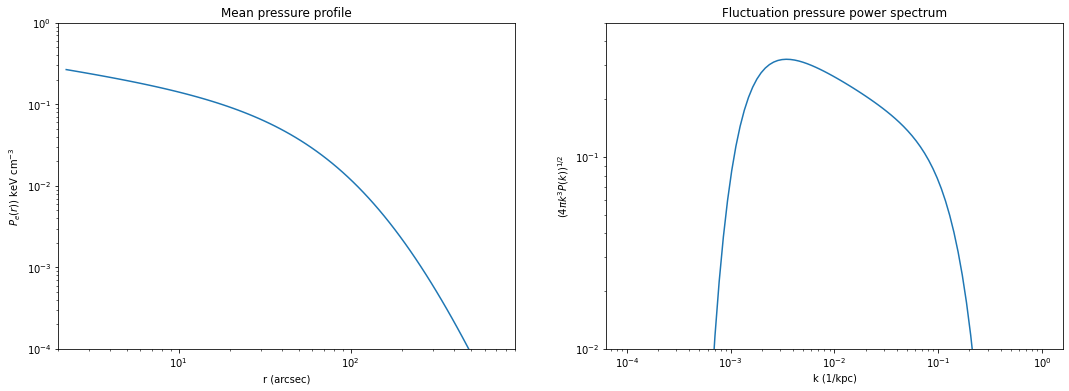

In [3]:
r, p_r = c.get_pressure_profile(radius=np.logspace(1,4,100)*u.kpc)

k, pk = c.get_pressure_fluctuation_spectrum(kvec=np.logspace(-1,3,100)*u.Mpc**-1)

plt.figure(0, figsize=(18,6))
ax = plt.subplot(1, 2, 1)
plt.loglog(r/c.D_ang.to_value('kpc')*180/np.pi*3600, p_r)
plt.xlabel('r (arcsec)')
plt.ylabel(r'$P_e(r))$ keV cm$^{-3}$')
plt.title('Mean pressure profile')
plt.ylim(1e-4,1e0)
plt.xlim(2e0,9e2)

ax = plt.subplot(1, 2, 2)
plt.loglog(k.to_value('kpc-1'), np.sqrt(4*np.pi*k**3*pk).to_value(''))
plt.xlabel('k (1/kpc)')
plt.ylabel(r'$(4 \pi k^3 P(k))^{1/2}$')
plt.ylim(1e-2,5e-1)
plt.title('Fluctuation pressure power spectrum')

# Cluster realization 

In [4]:
pressure3d_sph  = c.get_pressure_cube_profile()
fluct3d     = c.get_pressure_cube_fluctuation(seed=seed)
compton     = c.get_sz_map(seed=seed)
compton_sph = c.get_sz_map(no_fluctuations=True)

----- INFO: interpolation of the input Pk in the sampling box.
            input    k = [ 0.0005 , 0.4 ] kpc^-1
            sampling k = [ 0.0001996007984031936 , 0.058839660688646815 ] kpc^-1
            Sampling box k modes that are beyond the interpolation range are set to 0.
----- INFO: isotropy and k=0 mode.
            Modes with k=0 are set to 0.
            The maximum sampling k for having isotropy is  0.022046266687985618  kpc^-1
            This corresponds to a Nyquist sampling resolution  22.679576867882176  kpc
----- INFO: fluctuation cube rms.
            Expected rms over the full k range: 0.5
            Expected rms given the missing k range: 0.47778451310894765
            Actual rms for this noise realization: 0.4775812063136397
----- INFO: interpolation of the input Pk in the sampling box.
            input    k = [ 0.0005 , 0.4 ] kpc^-1
            sampling k = [ 0.0001996007984031936 , 0.058839660688646815 ] kpc^-1
            Sampling box k modes that are beyond

# Pk measurement

In [5]:
# Input 3D Pk
k_input, pk_input = c.get_pressure_fluctuation_spectrum(kvec=np.logspace(-4,0,100)*u.kpc**-1)

In [6]:
# Recovered 3D Pk from delta P cube
k_meas, pk_meas = pitszi.utils.get_pk3d(fluct3d, 
                                        c.map_reso.to_value('radian')*c.D_ang.to_value('kpc'), 
                                        c.los_reso.to_value('kpc'))

Text(0.5, 1.0, 'delta y / y spherical')

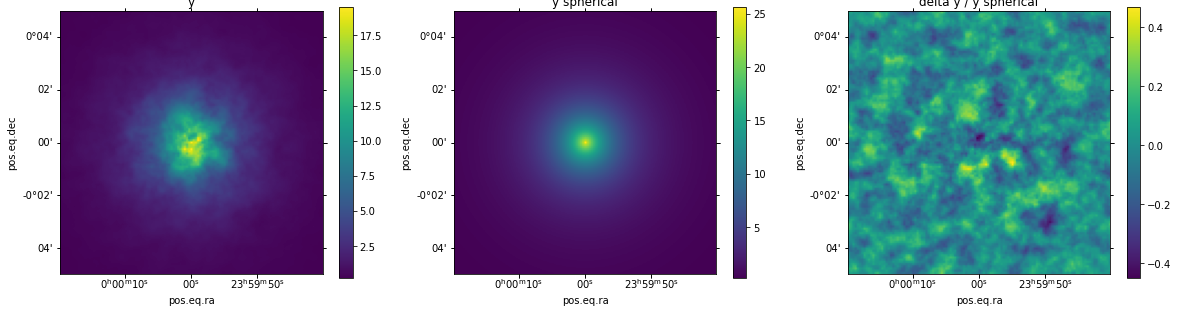

In [7]:
# Recovered 2D spectrum
compton_fluct = (compton - compton_sph)/compton_sph

k2d_meas, pk2d_meas = pitszi.utils.get_pk2d(compton_fluct, c.map_reso.to_value('radian')*c.D_ang.to_value('kpc'), 
                                            Nbin=100, scalebin='lin', 
                                            kmin=None, kmax=None,
                                            apply_volume=False)

#----- Show the pressure fluctuation cube slice
plt.figure(figsize=(20,5))
ax = plt.subplot(1, 3, 1, projection=WCS(c.get_map_header()))
plt.imshow(compton*1e5)
plt.colorbar()
plt.title('y')

ax = plt.subplot(1, 3, 2, projection=WCS(c.get_map_header()))
plt.imshow(compton_sph*1e5)
plt.colorbar()
plt.title('y spherical')

ax = plt.subplot(1, 3, 3, projection=WCS(c.get_map_header()))
plt.imshow(compton_fluct)
plt.colorbar()
plt.title('delta y / y spherical')

Text(0.5, 1.0, 'SZ fluctuation power spectrum')

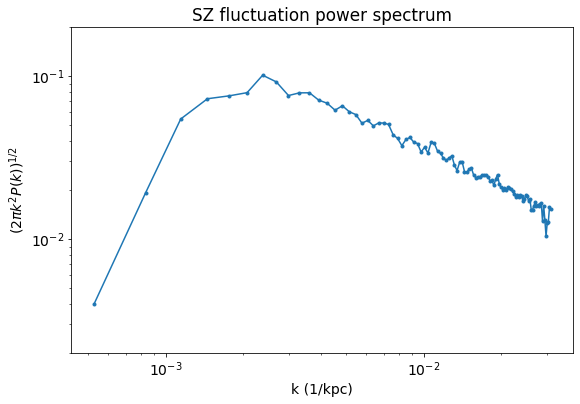

In [8]:
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(9,6))
#plt.loglog(k_input, (np.sqrt(4*np.pi*k_input**3*pk_input)).to_value(''))
#plt.loglog(k_meas, np.sqrt(4*np.pi*k_meas**3*pk_meas), ls='-', marker='o')
plt.loglog(k2d_meas, np.sqrt(2*np.pi*k2d_meas**2*pk2d_meas), ls='-', marker='.')
plt.ylim(1e-2,1)
plt.xlabel('k (1/kpc)')
#plt.ylabel(r'$(4 \pi k^3 P(k))^{1/2}$')
plt.ylabel(r'$(2 \pi k^2 P(k))^{1/2}$')
plt.ylim(2e-3,2e-1)
plt.title('SZ fluctuation power spectrum')

# Window function

In [9]:
import astropy.constants as cst
from pitszi import utils
from astropy.coordinates import SkyOffsetFrame
from scipy.spatial.transform import Rotation as R
from scipy.interpolate import interp1d

### Compute the window function in real space

In [10]:
compton3d = np.repeat(compton_sph[:,:,np.newaxis], pressure3d_sph.shape[2], axis=2)
W3d = (cst.sigma_T / (cst.m_e * cst.c**2)* pressure3d_sph / compton3d).to('kpc-1')

Nx, Ny, Nz, proj_reso, proj_reso, los_reso = c.get_3dgrid()
map_center = c.get_map_center()
offset = (c._coord).transform_to(SkyOffsetFrame(origin=map_center))
dRA    = offset.data.lon.to_value('radian')
dDec   = offset.data.lat.to_value('radian')
dx     = dRA*c._D_ang.to_value('kpc')   # Offset map along x
dy     = dDec*c._D_ang.to_value('kpc')  # Offset map along y
ctr_xpix_vec = np.linspace(-Nx*proj_reso/2, Nx*proj_reso/2, Nx) + dx
ctr_ypix_vec = np.linspace(-Ny*proj_reso/2, Ny*proj_reso/2, Ny) - dy
ctr_zpix_vec = np.linspace(-Nz*los_reso/2,  Nz*los_reso/2,  Nz)
coord_x, coord_y, coord_z = np.meshgrid(ctr_xpix_vec, ctr_ypix_vec, ctr_zpix_vec, indexing='ij')
angle_1 = c._triaxiality['euler_angle1'].to_value('deg')
angle_2 = c._triaxiality['euler_angle2'].to_value('deg')
angle_3 = c._triaxiality['euler_angle3'].to_value('deg')
rot = R.from_euler('ZXZ', [angle_1, angle_2, angle_3], degrees=True)
coordinates = np.stack((coord_x, coord_y, coord_z), axis=-1)
coordinates_reshape = coordinates.reshape(-1, 3)
rotated_coordinates = rot.apply(coordinates_reshape).reshape(coord_x.shape + (3,))
rot_coord_x = rotated_coordinates[:,:,:,0] / c._triaxiality['min_to_maj_axis_ratio']
rot_coord_y = rotated_coordinates[:,:,:,1] / c._triaxiality['int_to_maj_axis_ratio']
rot_coord_z = rotated_coordinates[:,:,:,2]

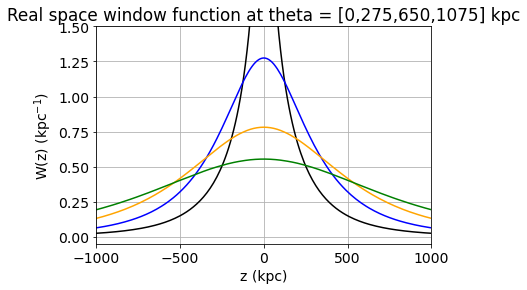

In [11]:
pix1   = int(275*Nx/2/np.amax(rot_coord_x[:,0,0]))
pix2   = int(650*Nx/2/np.amax(rot_coord_x[:,0,0]))
pix3   = int(1075*Nx/2/np.amax(rot_coord_x[:,0,0]))
try:
    plt.plot(rot_coord_z[0,0,:], W3d[int(W3d.shape[0]/2),int(W3d.shape[1]/2),:]*1e3, color='k') # Center
except:
    print('pix0 not possible')
try:
    plt.plot(rot_coord_z[0,0,:], W3d[int(W3d.shape[0]/2)+pix1,int(W3d.shape[1]/2),:]*1e3, color='b')
except:
    print('pix1 not possible')
try:
    plt.plot(rot_coord_z[0,0,:], W3d[int(W3d.shape[0]/2)+pix2,int(W3d.shape[1]/2),:]*1e3, color='orange')
except:
    print('pix2 not possible')
try:
    plt.plot(rot_coord_z[0,0,:], W3d[int(W3d.shape[0]/2)+pix3,int(W3d.shape[1]/2),:]*1e3, color='g')
except:
    print('pix3 not possible')
plt.xlim(-1000,1000)
plt.ylim(-0.05,1.5)
plt.xlabel('z (kpc)')
plt.ylabel('W(z) (kpc$^{-1}$)')
plt.title('Real space window function at theta = [0,275,650,1075] kpc')
plt.grid()

### Compute the window function in Fourier space

In [12]:
k_x = np.fft.fftfreq(Nx, proj_reso) # 1/kpc
k_y = np.fft.fftfreq(Ny, proj_reso)
k_z = np.fft.fftfreq(Nz, los_reso)
k3d_x, k3d_y, k3d_z = np.meshgrid(k_x, k_y, k_z, indexing='ij')
k3d_norm = np.sqrt(k3d_x**2 + k3d_y**2 + k3d_z**2)
k3d_norm_flat = k3d_norm.flatten()

W_ft = np.abs(np.fft.fft(W3d.to_value('kpc-1'), axis=2))**2 * c.los_reso.to_value('kpc')**2

Text(0, 0.5, '$|\\tilde{W}(k_z)|^2$')

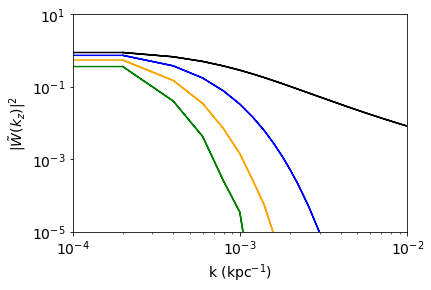

In [13]:
try:
    plt.loglog(np.sqrt(k_z**2), W_ft[int(W_ft.shape[0]/2),int(W_ft.shape[1]/2),:], color='k')
except:
    print('pix0 not possible')
try:
    plt.loglog(np.sqrt(k_z**2), W_ft[int(W_ft.shape[0]/2)+pix1,int(W_ft.shape[1]/2),:], color='b')
except:
    print('pix1 not possible')
try:
    plt.loglog(np.sqrt(k_z**2), W_ft[int(W_ft.shape[0]/2)+pix2,int(W_ft.shape[1]/2),:], color='orange')
except:
    print('pix2 not possible')
try:
    plt.loglog(np.sqrt(k_z**2), W_ft[int(W_ft.shape[0]/2)+pix3,int(W_ft.shape[1]/2),:], color='g')
except:
    print('pix3 not possible')
plt.ylim(1e-5,1e1)
plt.xlim(1e-4,1e-2)

plt.xlabel('k (kpc$^{-1}$)')
plt.ylabel(r'$|\tilde{W}(k_z)|^2$')

### Compute the 2d to 3d Pk

In [14]:
#----- Get the values for a few theta
'''
fact = 2
sort = np.argsort(np.sqrt(k_z**2))
func0 = (W_ft[int(W_ft.shape[0]/2),int(W_ft.shape[1]/2),:])[sort]
func1 = (W_ft[int(W_ft.shape[0]/2)+pix1,int(W_ft.shape[1]/2),:])[sort]
func2 = (W_ft[int(W_ft.shape[0]/2)+pix2,int(W_ft.shape[1]/2),:])[sort]
func3 = (W_ft[int(W_ft.shape[0]/2)+pix3,int(W_ft.shape[1]/2),:])[sort]
kvec_norm = (np.sqrt(k_z**2))[sort]

N_theta0 = utils.trapz_loglog(func0, kvec_norm) * fact  # Be carefull here for numerics near k=0...
N_theta1 = utils.trapz_loglog(func1, kvec_norm) * fact
N_theta2 = utils.trapz_loglog(func2, kvec_norm) * fact
N_theta3 = utils.trapz_loglog(func3, kvec_norm) * fact
'''

fact = 1
sort = np.argsort(k_z)
func0 = (W_ft[int(W_ft.shape[0]/2),int(W_ft.shape[1]/2),:])[sort]
func1 = (W_ft[int(W_ft.shape[0]/2)+pix1,int(W_ft.shape[1]/2),:])[sort]
func2 = (W_ft[int(W_ft.shape[0]/2)+pix2,int(W_ft.shape[1]/2),:])[sort]
kvec_norm = k_z[sort]

N_theta0 = utils.trapz_loglog(func0, kvec_norm) * fact  # Be carefull here for numerics near k=0...
N_theta1 = utils.trapz_loglog(func1, kvec_norm) * fact
N_theta2 = utils.trapz_loglog(func2, kvec_norm) * fact

N_theta0*1e4, N_theta1*1e4, N_theta2*1e4

(21.85459354923783, 7.34100432439154, 4.584257221138302)

21.85459354923783 7.34100432439154 4.584257221138302


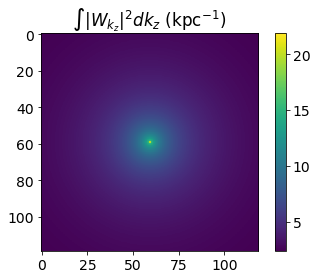

In [15]:
#----- Get the corresponding map
W_ft_shift = np.fft.fftshift(W_ft, axes=2)
N_theta = utils.trapz_loglog(W_ft_shift, kvec_norm, axis=2)*fact*u.kpc**-1

plt.imshow(N_theta.to_value('kpc-1')*1e4)
plt.colorbar()
plt.title(r'$\int |W_{k_z}|^2 dk_z$ (kpc$^{-1}$)')
print(N_theta.value[int(W_ft.shape[0]/2),int(W_ft.shape[1]/2)]*1e4, 
      N_theta.value[int(W_ft.shape[0]/2)+pix1,int(W_ft.shape[1]/2)]*1e4, 
      N_theta.value[int(W_ft.shape[0]/2)+pix2,int(W_ft.shape[1]/2)]*1e4)

In [16]:
#----- Compute the Pk2d from Pk3d
Pk2d_pred = pk_input*np.mean(N_theta)

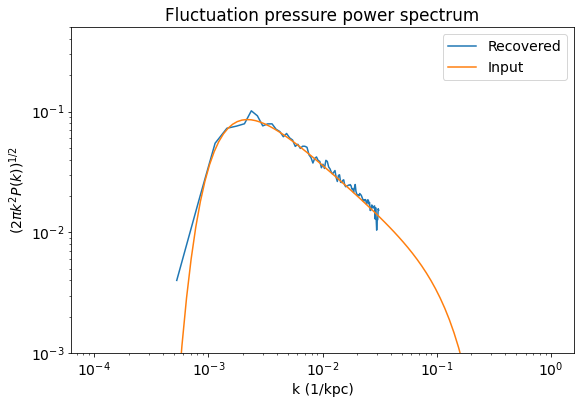

In [17]:
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(9,6))
plt.loglog(k2d_meas, np.sqrt(2*np.pi*k2d_meas**2*pk2d_meas), label='Recovered')
plt.loglog(k_input, (np.sqrt(2*np.pi*k_input**2*Pk2d_pred)).to_value(''), label='Input')
plt.xlabel('k (1/kpc)')
plt.ylabel(r'$(2 \pi k^2 P(k))^{1/2}$')
plt.ylim(1e-3,5e-1)
plt.title('Fluctuation pressure power spectrum')
plt.legend()

In [18]:
infer = pitszi.Inference(0, c)
Ntheta_map = infer.get_p3d_to_p2d_from_window_function()

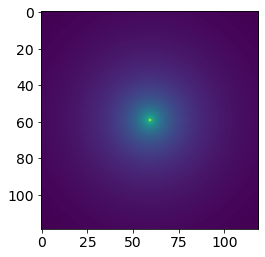

In [19]:
plt.imshow(Ntheta_map.value)

In [20]:
np.amin(Ntheta_map.value/N_theta.value), np.amax(Ntheta_map.value/N_theta.value)

(1.0, 1.0)